# SMOTE

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/GitHub/BP24/IRIS.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


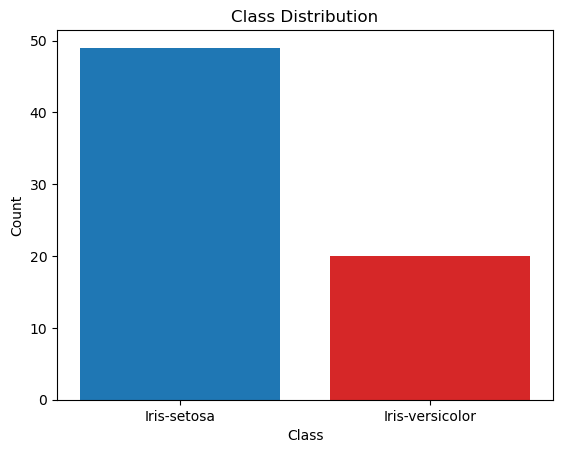

species
Iris-setosa        49
Iris-versicolor    20
Name: count, dtype: int64

In [3]:
# Data exploration
x=df.drop(['species'],axis=1)[1:70] # 150 rows -> 70 rows to match with created imbalance
y=df['species'][1:70] # creating imbalance
count_class=df['species'][1:70].value_counts()
bar_colors = ['tab:blue', 'tab:red']
plt.bar(count_class.index, count_class.values, color=bar_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Iris-setosa', 'Iris-versicolor'])
plt.show()
y.value_counts()

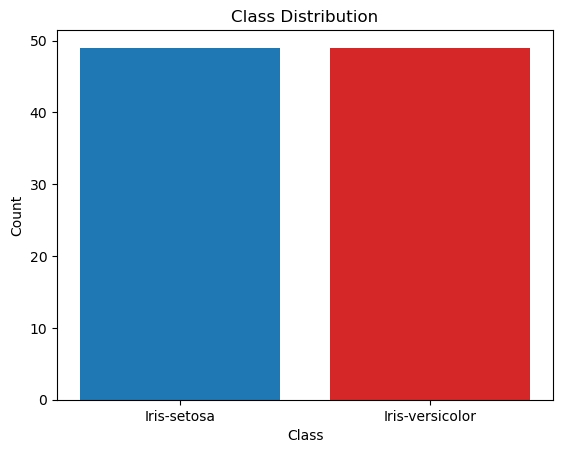

species
Iris-setosa        49
Iris-versicolor    49
Name: count, dtype: int64

In [4]:
# SMOTE to balance species classes
smote=SMOTE(sampling_strategy='minority')  # generating synthetic samples for minority class
x,y=smote.fit_resample(x,y) # re-sampling
y.value_counts() # Looking at counts post-SMOTE algoirthm

count_class=y.value_counts()
bar_colors = ['tab:blue', 'tab:red']
plt.bar(count_class.index, count_class.values, color=bar_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Iris-setosa', 'Iris-versicolor'])
plt.show()
y.value_counts()

# pmone & modpmone

In [6]:
import random
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def betterApplyAugmentationMethods(X_train, method, nrows, nvalues=None, unit=None, noise=None):
    # If nvalues not specified, entire column is selected
    if nvalues is None:
        nvalues = X_train.shape[1] - 1

    if str(method).lower() == 'pmone':
        # Creates empty dataframe to store augmented data
        augmentedDf = pd.DataFrame()

        # Randomly selects rows from data and appends to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Selects nvalues amount of unique column indexes
        randCols = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Iterates through augmentedData and applies plus or minus to randCols indexes
        for i in range(augmentedDf.shape[0]):
            for col in randCols:
                if (random.randint(0, 1) == 0):
                    augmentedDf.iloc[i, col] += unit
                else:
                    augmentedDf.iloc[i, col] -= unit

        return augmentedDf

    elif str(method).lower() == 'modpmone':
        # Creates empty dataframe to store augmented data
        augmentedDf = pd.DataFrame()

        # Randomly selects rows from data and appends to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Selects nvalues amount of unique column indexes
        randCols = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Iterates through augmentedData and applies plus or minus to randCols indexes
        for i in range(augmentedDf.shape[0]):
            for col in randCols:
                colMax = X_train.iloc[:, col].max()
                colMin = X_train.iloc[:, col].min()

                if (augmentedDf.iloc[i, col] + unit < colMax and augmentedDf.iloc[i, col] - unit > colMin):
                    if (random.randint(0, 1) == 0):
                        if (augmentedDf.iloc[i, col] + unit <= colMax):
                            augmentedDf.iloc[i, col] += unit
                        else:
                            augmentedDf.iloc[i, col] -= unit
                    else:
                        if (augmentedDf.iloc[i, col] - unit >= colMin):
                            augmentedDf.iloc[i, col] -= unit
                        else:
                            augmentedDf.iloc[i, col] += unit

        return augmentedDf

    elif str(method).lower() == 'gausnoise':
        # Creates empty dataframe to hold augmented rows
        augmentedDf = pd.DataFrame()

        # Selects random rows from data and appends to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Selects random unique column index
        randCols = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Applies Gaussian noise to randCols values stored in array
        for i in range(augmentedDf.shape[0]):
            for cols in randCols:
                augmentedDf.iloc[i, cols] += np.random.normal(0, noise)

        return augmentedDf

    elif str(method).lower() == 'modgausnoise':
        # Creates an empty dataframe to hold augmented observations
        augmentedDf = pd.DataFrame()

        # Randomly selects unique column indexs from data
        randCols = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Appends randomly selected rows from data to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Generates Gaussian distribution based on columns summary statistics
        # Swaps value with random value in generated Gaussian distribution
        for col in randCols:
            for i in range(augmentedDf.shape[0]):
                mean = augmentedDf[col].mean()
                stDev = augmentedDf[col].std()

                augmentedDf.iloc[i, col] = np.random.normal(mean, stDev)

        return augmentedDf

    elif str(method).lower() == 'randswap':
        # Creates empty dataframe to store augmented rows
        augmentedDf = pd.DataFrame()

        # Copies nrows from original data and appends to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Picks UNIQUE column indexes to swap
        columnIndexSwaps = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Swaps augmentedDf column value from same column in data
        for i in range(augmentedDf.shape[0]):
            for col in columnIndexSwaps:
                randValue = X_train.iloc[random.randint(0, X_train.shape[0] - 1), col]

                augmentedDf.iloc[i, col] = randValue

        return augmentedDf

    else:
        print("Method not found")
        return None
    

In [7]:
# NOTES: 
# nrows; # of rows you want created 
# nvalues: # of values in column to change
# unit: unit you want to change your values by 

# Converting the string column to int
species_mapping = {
    'Iris-setosa': 1,
    'Iris-versicolor': 2,
    'Iris-virginica': 3
}
df['species'] = df['species'].map(species_mapping)


In [8]:
x = df.drop(['species'], axis=1)
y = df['species']

# Train test split 
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    random_state=0,
                                                    test_size=0.25) 

# pmone
aug_dat1 = betterApplyAugmentationMethods(X_train, method='pmone', nrows=20, nvalues=None, unit=1, noise=None)
print(aug_dat1)

# modpmone
aug_dat2 = betterApplyAugmentationMethods(X_train, method='modpmone', nrows=20, nvalues=None, unit=1, noise=None)
print(aug_dat2)

    sepal_length  sepal_width  petal_length  petal_width
0            4.3          2.7           0.5          0.2
1            5.9          4.1           3.9          1.5
2            4.0          1.0           2.5          1.0
3            3.9          4.1           0.5          0.1
4            6.4          4.4           2.7          0.2
5            4.8          5.0           2.2          0.2
6            5.7          2.0           6.2          2.3
7            4.7          5.4           2.5          0.4
8            8.2          4.6           7.1          2.5
9            4.1          4.5           2.4          0.3
10           5.9          2.1           4.1          2.3
11           6.0          2.6           0.4          0.2
12           5.6          4.1           0.5          0.2
13           5.9          2.1           0.5          0.1
14           3.8          4.0           0.4          0.1
15           7.7          2.1           3.4          1.4
16           4.9          2.2  

In [9]:
print(df[0:14])

    sepal_length  sepal_width  petal_length  petal_width  species
0            5.1          3.5           1.4          0.2        1
1            4.9          3.0           1.4          0.2        1
2            4.7          3.2           1.3          0.2        1
3            4.6          3.1           1.5          0.2        1
4            5.0          3.6           1.4          0.2        1
5            5.4          3.9           1.7          0.4        1
6            4.6          3.4           1.4          0.3        1
7            5.0          3.4           1.5          0.2        1
8            4.4          2.9           1.4          0.2        1
9            4.9          3.1           1.5          0.1        1
10           5.4          3.7           1.5          0.2        1
11           4.8          3.4           1.6          0.2        1
12           4.8          3.0           1.4          0.1        1
13           4.3          3.0           1.1          0.1        1


# Chi-Squared Test for Feature Selection

A higher Chi-Square value means the feature is more dependent on the label. 

Steps: 
- Define a hypothesis
- Build a contingency table
- Find the expected values
- Calculate the Chi-Square statistics
- Accept/Reject the null hypothesis

Assumptions:
- The observations are independant
- No expected cell count is = 0
- No more than 20% of the cells have an expected cell coutn of <5

Current goal: try to figure out how to make contingency table for all features/figure out the chi-square for ALL FEATURES and LABEL (or ALL FEATURES generally)

In [28]:
############ CHI-SQUARE STAT FOR 2 VARIABLES ############
# Import relevant libraries 
import scipy.stats as stats

# Load new dataset
df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/GitHub/BP24/AceMejiaSanchez/Demo Code/fatal-police-shootings-data.csv")
df.head()

# Create contigency table
crosstab = pd.crosstab(df["manner_of_death"], df["body_camera"])
print(crosstab)

# Passing contingency table into chi-squared test
chi, p, dof, exp = stats.chi2_contingency(crosstab)
print(" ")
print("Chi-squared:", chi)
print("p-value:", p)

body_camera       False  True 
manner_of_death               
shot               4514    558
shot and Tasered    225     41
 
Chi-squared: 4.505484340744584
p-value: 0.03378632644086566


In [329]:
############ SELECTS FEATURES MOST CORRELATED WITH LABEL ############
import pandas as pd 
from sklearn.datasets import load_iris 
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 
  
# Load the dataset 
df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/GitHub/BP24/IRIS.csv")
x = df.drop(['species'], axis=1)
y = df['species']
  
print("Original Dataset:") 
print(df.head()) 
  
# Applying Chi-Square feature selection and 
# Selecting top k features 
k = 2 
chi2_selector = SelectKBest(chi2, k=k) 
X_new = chi2_selector.fit_transform(X, y) 
  
selected_features = df.columns[:-1][chi2_selector.get_support()] 
print("\nSelected Features:") 
print(selected_features)

Original Dataset:
   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Selected Features:
Index(['petal_length', 'petal_width'], dtype='object')


In [345]:
# Number of features, excluding label
var_count = 4

# Empty list
out = []

for i in range(0, var_count):

    # Create contigency table
    crosstab = pd.crosstab(df.iloc[:, i], df.loc[:, 'species'])

    # Passing contingency table into chi-squared test
    result = stats.chi2_contingency(crosstab)
    print(result)

Chi2ContingencyResult(statistic=156.26666666666668, pvalue=6.665987344005466e-09, dof=68, expected_freq=array([[0.33333333, 0.33333333, 0.33333333],
       [1.        , 1.        , 1.        ],
       [0.33333333, 0.33333333, 0.33333333],
       [1.33333333, 1.33333333, 1.33333333],
       [0.66666667, 0.66666667, 0.66666667],
       [1.66666667, 1.66666667, 1.66666667],
       [2.        , 2.        , 2.        ],
       [3.33333333, 3.33333333, 3.33333333],
       [3.        , 3.        , 3.        ],
       [1.33333333, 1.33333333, 1.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [2.        , 2.        , 2.        ],
       [2.33333333, 2.33333333, 2.33333333],
       [2.        , 2.        , 2.        ],
       [2.66666667, 2.66666667, 2.66666667],
       [2.33333333, 2.33333333, 2.33333333],
       [1.        , 1.        , 1.        ],
       [2.        , 2.        , 2.        ],
       [2.        , 2.        , 2.        ],
       [1.33333333, 1.33333333, 1.3333333